In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
no=3
temp_=np.loadtxt(f"temp_{no}.txt")

#RA  0      #DEC 1         #MAG_G  2     #MAG_I 3    
#ANGSEP 4   #RPROJ 5    
#SNR 6      #VTRUE 7       #VSTAT 8      #VSYS 9     
#VMEAS 10   #VMEASERR  11  #VSYSERR 12   #VERR 13 
nancut=~np.any(np.isnan(temp_),axis=-1)

temp_=temp_[nancut]
temp=temp_[:100*no].T
# the points need to be truncated for this analysis, read the README.md

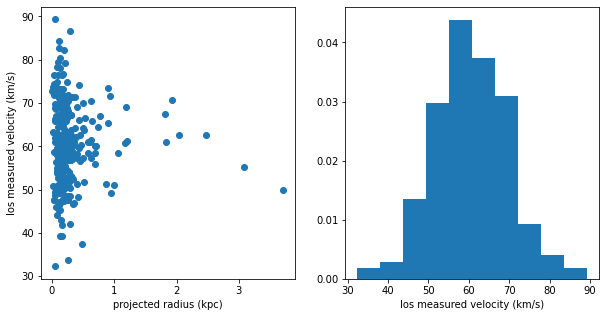

In [3]:

f,a=plt.subplots(1,2,figsize=(10,5))
a[0].plot(temp[5],temp[10],marker='o',linewidth=0)
a[0].set_xlabel('projected radius (kpc)')
a[0].set_ylabel('los measured velocity (km/s)')


a[1].hist(temp[10],density=True)
a[1].set_xlabel('los measured velocity (km/s)')
plt.show()

# Maximum Likelihood (frequentist)

We assume that the underlying distribution of these velocities is a gaussian with mean $\mu$ and dispersion $\sigma$. There is also a measurement error on each star of $e$, which means the errors are heteroscedastic. The data likelihood in this case is

\begin{align*}
\mathcal{L}=p(D | \mu,\sigma)&=\prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sqrt{\sigma^2+e_i^2}} \exp \left(-\frac{(x_i-\mu)^2}{2(\sigma^2+e_i^2)}\right)
\end{align*}
Then we can maximize the log-likelihood to maximize the likelihood
\begin{align*}
\ln\mathcal{L}&=-\frac{N}{2}\ln(2\pi)-\frac{1}{2}\sum_{i=1}^{N} \ln\left(\sigma^2+e_i^2\right) -\frac{1}{2}\sum_{i=1}^{N} \frac{(x_i-\mu)^2}{(\sigma^2+e_i^2)}
\end{align*}

This derivation is reaffirmed in equation 8 of Walker et al 2007 (https://arxiv.org/pdf/astro-ph/0511465.pdf)

In [4]:
npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)

mu,sg=np.meshgrid(mu_,sg_)

errors=temp[13]
measvs=temp[10]


#ignoring the constant first term which depends on the # of points but is constant for any particular data realization

lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
lnLi=np.array(lnLi)
lnL=np.sum(lnLi,axis=0)


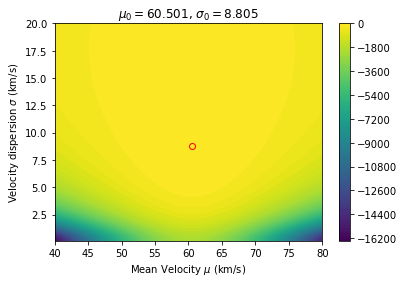

In [5]:
f,a=plt.subplots()

ind=np.unravel_index(lnL.argmax(), lnL.shape)

lnL=lnL-lnL[ind]
q=a.contourf(mu,sg,lnL,100)
a.plot(mu[ind],sg[ind],marker='o',markerfacecolor="None",markeredgecolor='red')
a.set_xlabel(r"Mean Velocity $\mu$ (km/s)")
a.set_ylabel(r"Velocity dispersion $\sigma$ (km/s)")
a.set_title(r"$\mu_0=$"+f"{mu[ind]:.3f}, " +r"$\sigma_0=$"+f"{sg[ind]:.3f}")
plt.colorbar(q)
plt.show()

# Bayesian Likelihood

Now instead of maximizing the data likelihood we maximize the posterior as:
\begin{align*}
p(\mu,\sigma | D)&=\frac{p( D|\mu,\sigma) p(\mu,\sigma)}{p(D)}
\end{align*}

And I think in this case we will assume that $p(\mu,\sigma)=p(\mu)p(\sigma)$ and because $\mu$ is a location parameter its prior is constant. Because $\sigma$ is a scale parameter, we will assume a prior of $1/\sigma$. Then

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [1.57948990e-119 2.90242476e-119 5.32707633e-119 ... 2.34052854e-112
  1.31503831e-112 7.37983581e-113]
 [1.69809958e-119 3.11665471e-119 5.71345841e-119 ... 2.43597679e-112
  1.37021572e-112 7.69820709e-113]
 [1.82417555e-119 3.34406801e-119 6.12307285e-119 ... 2.53355772e-112
  1.42671261e-112 8.02468611e-113]]
1620.8381636175761


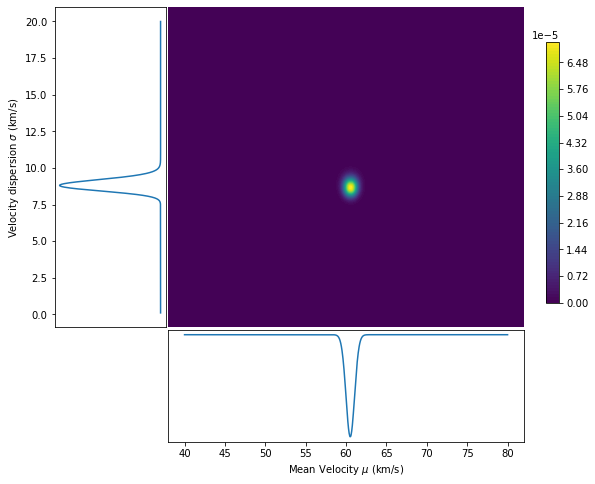

In [6]:
f,a=plt.subplots(2,2,figsize=(10,8),gridspec_kw={'width_ratios': [0.5, 2], 'height_ratios': [2,0.7]})

a[1,0].axis('off')
print(np.exp(lnL))
print(np.sum(np.exp(lnL)))
jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
q=a[0,1].contourf(mu,sg,jpdf,100)
a[0,1].axis('off')

marg_mu=np.sum(jpdf,axis=0)
a[1,1].plot(mu_,marg_mu)
a[1,1].set_xlabel(r"Mean Velocity $\mu$ (km/s)")
a[1,1].set_yticks([])
a[1,1].invert_yaxis()

marg_sg=np.sum(jpdf,axis=1)
a[0,0].plot(marg_sg,sg_)
a[0,0].set_ylabel(r"Velocity dispersion $\sigma$ (km/s)")
a[0,0].set_xticks([])
a[0,0].invert_xaxis()

plt.subplots_adjust(wspace=0.01,hspace=0.01)
f.colorbar(q, ax=a[:, 1], shrink=0.6,anchor=(0.0,0.8))
plt.show()

In [7]:
cdf_mu=np.cumsum(marg_mu)/np.sum(marg_mu)
cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

print(np.argmin( (cdf_mu-0.500)**2))

mu_med=mu_[np.argmin( (cdf_mu-0.500)**2)]
sg_med=sg_[np.argmin( (cdf_sg-0.500)**2)]
mu_upp=mu_[np.argmin( (cdf_mu-0.841)**2)]
sg_upp=sg_[np.argmin( (cdf_sg-0.841)**2)]
mu_low=mu_[np.argmin( (cdf_mu-0.159)**2)]
sg_low=sg_[np.argmin( (cdf_sg-0.159)**2)]

print(f'mu = {mu_med} + {mu_upp-mu_med} - {mu_med-mu_low}')
print(f'mu = {sg_med} + {sg_upp-sg_med} - {sg_med-sg_low}')

512
mu = 60.5005005005005 + 0.5205205205205203 - 0.5205205205205203
mu = 8.824924924924924 + 0.39839839839839897 - 0.3784784784784776


And the velocity dispersion is consistent with 9.1 ± 1.2 found in Walker et al 2009 (https://arxiv.org/pdf/0906.0341.pdf). Not specifically the uncertainty, because that measurement was made with M2FS and this simulation assumes a different number of stars. But you know, the point is that the simulation broadly kind of works and results in observations.

# The Question

Does increasing the number of stars observed, at the expense of the time each star is observed, decrease the uncertainty of the velocity dispersion?

In [8]:
mu_meds=[]
sg_meds=[]
mu_upps=[]
sg_upps=[]
mu_lows=[]
sg_lows=[]
nframes=[1,2,3,4,5,6,7,8,9,10]

npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)
mu,sg=np.meshgrid(mu_,sg_)

for no in nframes:
    temp_=np.loadtxt(f"temp_{no}.txt")
    nancut=~np.any(np.isnan(temp_),axis=-1)
    temp_=temp_[nancut]
    temp=temp_[:100*no].T
    
    errors=temp[13]
    measvs=temp[10]

    #ignoring the constant first term which depends on the # of points but is constant for any particular data realization
    lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
    lnLi=np.array(lnLi)
    lnL=np.sum(lnLi,axis=0)
    lnL=lnL-lnL[ind]
    
    jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
    marg_mu=np.sum(jpdf,axis=0)
    marg_sg=np.sum(jpdf,axis=1)
    
    cdf_mu=np.cumsum(marg_mu)/np.sum(marg_mu)
    cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

    mu_meds.append(mu_[np.argmin( (cdf_mu-0.500)**2)])
    sg_meds.append(sg_[np.argmin( (cdf_sg-0.500)**2)])
    mu_upps.append(mu_[np.argmin( (cdf_mu-0.841)**2)])
    sg_upps.append(sg_[np.argmin( (cdf_sg-0.841)**2)])
    mu_lows.append(mu_[np.argmin( (cdf_mu-0.159)**2)])
    sg_lows.append(sg_[np.argmin( (cdf_sg-0.159)**2)])

In [9]:
sg_upe=[sg_upps[i]-sg_meds[i] for i in range(len(sg_meds))]
sg_lwe=[sg_meds[i]-sg_lows[i] for i in range(len(sg_meds))]

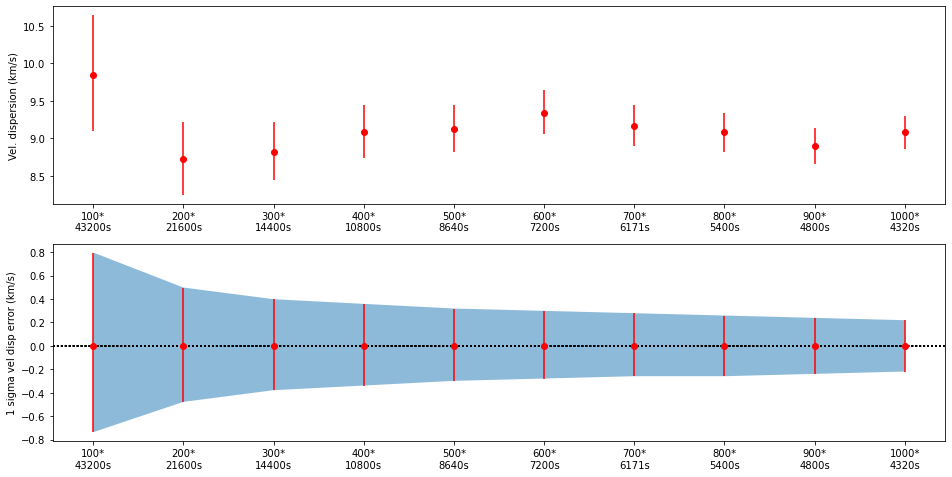

In [10]:
f,a=plt.subplots(2,figsize=(16,8))
tottime=12*3600
for i in range(len(nframes)):
    a[0].errorbar(nframes[i],sg_meds[i],yerr=[[sg_lwe[i]],[sg_upe[i]]],color='red',marker='o')
    a[0].set_xticks(nframes)
    
    a[1].errorbar(nframes[i],0,yerr=[[sg_lwe[i]],[sg_upe[i]]],color='red',marker='o')
    a[1].axhline(0,linestyle='dotted',color='black')
    a[1].set_xticks(nframes)
a[0].set_ylabel("Vel. dispersion (km/s)")
a[0].set_xticklabels([f"{100*nframes[j]}*\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])

a[1].fill_between(nframes,[-i for i in sg_lwe],sg_upe,alpha=0.5)

a[1].set_ylabel("1 sigma vel disp error (km/s)")
a[1].set_xticklabels([f"{100*nframes[j]}*\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])
plt.show()

# Fitting the Dispersion as a function of number of seperate observations

Let's specifically use the 1 sigma interval as a parameter for "dispersion uncertainty".

In [12]:
sg_sigdif=[sg_lwe[i]+sg_upe[i] for i in range(len(sg_meds))]

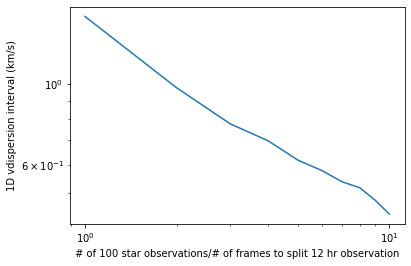

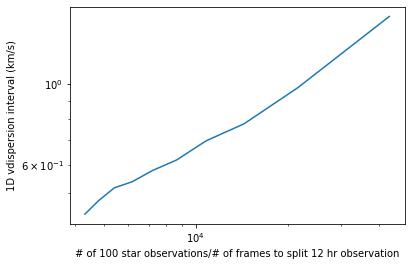

In [18]:
nfra=np.array(nframes)
sigdif=np.array(sg_sigdif)

f,a=plt.subplots()
a.plot(nfra,sigdif)
a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
a.set_yscale('log')
a.set_xscale('log')
plt.show()

# seems to have power law form

f,a=plt.subplots()
a.plot(tottime/nfra,sigdif)
a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
a.set_yscale('log')
a.set_xscale('log')
plt.show()

# seems to have power law form